### load raw human-virus data
1. Mark labels
2. merge with uniref 90/50 (NOTE: we have downloaded only SWP/SwissPRot UR 90/50 groups, not for all uniprot)
3. Train/test split? 
4. maybe - merge with static embedding features?
    * I try embeddings file - global average from unirpto , downloaded 130 k seqs for all reviewed human + virus seqs:
        * `https://rest.uniprot.org/uniprotkb/download/results/70954af38e9a8a48694cd8a784ba275123f491f8`
        * `uniprot_pt_hum_vir_swp_embeddings.h5`
    * https://www.uniprot.org/help/embeddings
    * `virus OR (taxonomy_id:33208) AND (reviewed:true)`
        * https://www.uniprot.org/uniprotkb?dir=descend&facets=reviewed:true&query=virus%20OR%20(taxonomy_id:33208)%20AND%20(reviewed:true)&sort=length


* Current input is Swisspot reviewed, human protein OR virus with known animal host (And reviewed). + Some length filtering `SWP_human_or_virus-animal`


* See also: `merge_uniref_swpid_clusters` - e.g. makes ur50-swp parquet,

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split,StratifiedGroupKFold

In [2]:
### if true: deduplicate ALL data by ur90, 50 roups ()
# FILT_UR90 = True
FILT_UR50 = False # 

FILT_TEST_UR50 = True ## if true, just for test set, split by UR 50? 

FASTRUN = False#True

MAX_LENGTH_FILTER = 512*3

In [3]:
df = pd.read_csv("SWP_human_or_virus-animal.tsv.gz",sep="\t",nrows= 800 if FASTRUN else 1e9)
df["av_mw"] = df["Mass"].div(df["Length"]).round(2)


## note - these 2 conditions are equivalent in the data but i use both for safety
df["virus"] = ((df["Taxonomic lineage"].str.contains("vir",case=False,na=False))| \
               (~df["Virus hosts"].isna())|\
              (df["Organism"].str.contains("virus",case=False,na=False))).astype(int)
print(df["virus"].agg(["mean","size","sum"]).round(2))

## not the same as baltimore classification! 9 uniques. 
df["taxon_class"] = df["Taxonomic lineage"].str.split(",",expand=True)[1].str.split(" ",expand=True)[1]
df

mean        0.37
size    32239.00
sum     11817.00
Name: virus, dtype: float64


,Entry,Entry Name,Protein names,Organism,Sequence,Length,Mass,Keywords,Reviewed,Virus hosts,Taxonomic lineage,av_mw,virus,taxon_class
0,A0A087X1C5,CP2D7_HUMAN,Putative cytochrome P450 2D7 (EC 1.14.14.1),Homo sapiens (Human),MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,515,57489,Cytoplasm;Glycoprotein;Heme;Iron;Membrane;Meta...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",111.63,0,Eukaryota
1,A0A0B4J2F0,PIOS1_HUMAN,Protein PIGBOS1 (PIGB opposite strand protein 1),Homo sapiens (Human),MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,54,6313,Direct protein sequencing;Membrane;Mitochondri...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",116.91,0,Eukaryota
2,A0A0B4J2F2,SIK1B_HUMAN,Putative serine/threonine-protein kinase SIK1B...,Homo sapiens (Human),MVIMSEFSADPAGQGQGQQKPLRVGFYDIERTLGKGNFAVVKLARH...,783,84930,ATP-binding;Kinase;Magnesium;Metal-binding;Nuc...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",108.47,0,Eukaryota
3,A0A0B5A886,GP_SFTSV,Envelopment polyprotein (M polyprotein) [Cleav...,SFTS phlebovirus (isolate SFTSV/Human/China/HB...,MMKVIWFSSLICLVIQCSGDSGPIICAGPIHSNKSAGIPHLLGYSE...,1073,116636,Disulfide bond;Fusion of virus membrane with h...,reviewed,Haemaphysalis longicornis (Bush tick) [TaxID: ...,"Viruses (superkingdom), Riboviria (no rank), O...",108.70,1,Riboviria
4,A0A0B5AC19,NSS_SFTSV,Non-structural protein NS-S (NSs),SFTS phlebovirus (isolate SFTSV/Human/China/HB...,MSLSKCSNVDLKSVAMNANTVRLEPSLGEYPTLRRDLVECSCSVLT...,293,33793,Host cytoplasm;Host cytoplasmic vesicle;Host G...,reviewed,Haemaphysalis longicornis (Bush tick) [TaxID: ...,"Viruses (superkingdom), Riboviria (no rank), O...",115.33,1,Riboviria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32234,Q9YUD4,ORF3_BFDV,Uncharacterized protein ORF3,Beak and feather disease virus (BFDV),MPYVDFWELSRDFLHFASGHHGSNSSVERAVTVSRHNAQGEYNVPL...,160,17738,NaN,reviewed,Gracula [TaxID: 116991]; Psittaciformes [TaxID...,"Viruses (superkingdom), Monodnaviria (no rank)...",110.86,1,Monodnaviria
32235,Q9YWQ0,NS3_BAVJK,Non-structural protein 3 (NS3),Banna virus (strain Indonesia/JKT-6423/1980) (...,MNNGQATITRNGGRFEIRCRHLDRDYTMPLPNATSNDNFLDCIKFI...,306,34991,Reference proteome,reviewed,Bos taurus (Bovine) [TaxID: 9913]; Culex annul...,"Viruses (superkingdom), Riboviria (no rank), O...",114.35,1,Riboviria
32236,Q9YZN9,C_MEASC,Protein C,Measles virus (strain Ichinose-B95a) (MeV) (Su...,MSKTDWNASGLSRPSPSAHWPSRKPWQHGQKYQTTQDRTEPPARKR...,186,21106,Reference proteome,reviewed,Homo sapiens (Human) [TaxID: 9606],"Viruses (superkingdom), Riboviria (no rank), O...",113.47,1,Riboviria
32237,X6R8D5,GUCNB_HUMAN,Putative uncharacterized protein GUCA1ANB (GUC...,Homo sapiens (Human),MGRKEHESPSQPHMCGWEDSQKPSVPSHGPKTPSCKGVKAPHSSRP...,127,14531,Reference proteome,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",114.42,0,Eukaryota


In [4]:
df["Taxonomic lineage"].str.split(",",expand=True)[1].str.split(" ",expand=True)[1].value_counts()

Eukaryota              20422
Riboviria               5031
Varidnaviria            3234
Duplodnaviria           2223
Monodnaviria             767
Naldaviricetes           402
Anelloviridae             72
Polydnaviriformidae       53
Ribozyviria               35
Name: 1, dtype: int64

In [5]:
df["Taxonomic lineage"].str.split(",",expand=True)[2].str.split(" ",expand=True)[1].value_counts()

Opisthokonta          20422
Orthornavirae          3759
Bamfordvirae           3234
Heunggongvirae         2223
Pararnavirae           1269
Shotokuvirae            767
Lefavirales             399
Bracoviriform            52
Kolmioviridae            35
Alphatorquevirus         18
unclassified             17
Gyrovirus                16
Epsilontorquevirus        4
Deltatorquevirus          3
Etatorquevirus            3
Zetatorquevirus           3
Betatorquevirus           3
Iotatorquevirus           3
Thetatorquevirus          3
Nimaviridae               3
Gammatorquevirus          2
Ichnoviriform             1
Name: 1, dtype: int64

In [6]:
df.groupby("virus").describe(percentiles=[]).round(1).T

virus                 0         1
Length count    20422.0   11817.0
       mean       557.8     399.9
       std        599.5     313.7
       min          2.0      11.0
       50%        415.0     313.0
       max      34350.0    1986.0
Mass   count    20422.0   11817.0
       mean     62129.2   45077.2
       std      66404.3   35141.9
       min        260.0    1271.0
       50%      46198.5   35361.0
       max    3816030.0  225243.0
av_mw  count    20422.0   11817.0
       mean       111.5     113.2
       std          3.5       3.4
       min         72.5      88.0
       50%        111.8     113.2
       max        138.2     129.1

In [7]:
df = df.loc[df["Length"]<=MAX_LENGTH_FILTER]
print(df.shape[0])

31270


In [8]:
# df[df["Taxonomic lineage"].str.contains("vir",case=False,na=False)] # identical, 6734 rows
# print(df[~df["Virus hosts"].isna()].shape[0] # same number of results)

### filter y Uniref 90 clusters

* Note: UR90 clusters do not includes sequences shorter than 11
* Note: these are from swissprot

In [9]:
df_90 = pd.read_csv("../clusters_uniref-90-swissprot.tsv.gz",sep="\t",usecols=['Cluster ID',
#                                                                                "Common taxon", ## leak if used
                                                                               'Cluster name'])#  #"clusters_uniref-50-swissprot.tsv.gz""
# ### NOT SURE IF CORRECT! Possibly uniprot seq id for the ref sequence:
df_90["Cluster ID"] = df_90["Cluster ID"].str.replace("UniRef[0-9]{2,3}_","",regex=True,case=False).str.strip()
df_90

,Cluster ID,Cluster name
0,Q09449,Cluster: Uncharacterized ATP-dependent helicas...
1,Q05471,Cluster: Helicase SWR1
2,Q64446,Cluster: Copper-transporting ATPase 2
3,Q7Z494,Cluster: Nephrocystin-3
4,O55207,Cluster: Synaptojanin-2
...,...,...
355604,A7GMV1,Cluster: Phosphoribosyl-AMP cyclohydrolase
355605,O06492,Cluster: Glutamyl-tRNA(Gln) amidotransferase s...
355606,Q8EF98,Cluster: Integration host factor subunit alpha
355607,Q99JY6,Cluster: HIG1 domain family member 1B


In [10]:
df = df.merge(df_90,left_on="Entry",right_on="Cluster ID",how="inner")
print(df.shape[0],"rows after merging")

print(df["virus"].agg(["mean","size","sum"]).round(2))
df

25119 rows after merging
mean        0.27
size    25119.00
sum      6699.00
Name: virus, dtype: float64


,Entry,Entry Name,Protein names,Organism,Sequence,Length,Mass,Keywords,Reviewed,Virus hosts,Taxonomic lineage,av_mw,virus,taxon_class,Cluster ID,Cluster name
0,A0A087X1C5,CP2D7_HUMAN,Putative cytochrome P450 2D7 (EC 1.14.14.1),Homo sapiens (Human),MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,515,57489,Cytoplasm;Glycoprotein;Heme;Iron;Membrane;Meta...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",111.63,0,Eukaryota,A0A087X1C5,Cluster: Putative cytochrome P450 2D7
1,A0A0B4J2F0,PIOS1_HUMAN,Protein PIGBOS1 (PIGB opposite strand protein 1),Homo sapiens (Human),MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,54,6313,Direct protein sequencing;Membrane;Mitochondri...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",116.91,0,Eukaryota,A0A0B4J2F0,Cluster: Protein PIGBOS1
2,A0A0C5B5G6,MOTSC_HUMAN,Mitochondrial-derived peptide MOTS-c (Mitochon...,Homo sapiens (Human),MRWQEMGYIFYPRKLR,16,2175,DNA-binding;Mitochondrion;Nucleus;Osteogenesis...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",135.94,0,Eukaryota,A0A0C5B5G6,Cluster: Mitochondrial-derived peptide MOTS-c
3,A0A0K2S4Q6,CD3CH_HUMAN,Protein CD300H (CD300 antigen-like family memb...,Homo sapiens (Human),MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,201,21806,Alternative splicing;Disulfide bond;Glycoprote...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",108.49,0,Eukaryota,A0A0K2S4Q6,Cluster: Protein CD300H
4,A0A0U1RRE5,NBDY_HUMAN,Negative regulator of P-body association (P-bo...,Homo sapiens (Human),MGDQPCASGRSTLPPGNAREAKPPKKRCLLAPRWDYPEGTPNGGST...,68,7025,Cytoplasm;mRNA processing;Reference proteome,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",103.31,0,Eukaryota,A0A0U1RRE5,Cluster: Negative regulator of P-body association
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25114,Q9YUD1,ORF6_BFDV,Uncharacterized protein ORF6,Beak and feather disease virus (BFDV),MKTSPRLSVIDGVGEEVRPDLFQLVHVVPPNTCEPPEQWLRVTVLL...,88,9846,NaN,reviewed,Gracula [TaxID: 116991]; Psittaciformes [TaxID...,"Viruses (superkingdom), Monodnaviria (no rank)...",111.89,1,Monodnaviria,Q9YUD1,Cluster: Uncharacterized protein ORF6
25115,Q9YUD2,ORF5_BFDV,Uncharacterized protein ORF5,Beak and feather disease virus (BFDV),MGGAYITSRYWLVPAHVTSRLRLTSFTGHRGVARVDGPMSSLGLNI...,101,10863,NaN,reviewed,Gracula [TaxID: 116991]; Psittaciformes [TaxID...,"Viruses (superkingdom), Monodnaviria (no rank)...",107.55,1,Monodnaviria,Q9YUD2,Cluster: Uncharacterized protein ORF5
25116,Q9YUD4,ORF3_BFDV,Uncharacterized protein ORF3,Beak and feather disease virus (BFDV),MPYVDFWELSRDFLHFASGHHGSNSSVERAVTVSRHNAQGEYNVPL...,160,17738,NaN,reviewed,Gracula [TaxID: 116991]; Psittaciformes [TaxID...,"Viruses (superkingdom), Monodnaviria (no rank)...",110.86,1,Monodnaviria,Q9YUD4,Cluster: Uncharacterized protein ORF3
25117,Q9YWQ0,NS3_BAVJK,Non-structural protein 3 (NS3),Banna virus (strain Indonesia/JKT-6423/1980) (...,MNNGQATITRNGGRFEIRCRHLDRDYTMPLPNATSNDNFLDCIKFI...,306,34991,Reference proteome,reviewed,Bos taurus (Bovine) [TaxID: 9913]; Culex annul...,"Viruses (superkingdom), Riboviria (no rank), O...",114.35,1,Riboviria,Q9YWQ0,Cluster: Non-structural protein 3


In [11]:
print(df.drop_duplicates(subset=["Cluster ID"]).shape[0])
print(df.drop_duplicates(subset=["Cluster ID","virus"]).shape[0])

25119
25119


Load previously exploded uniref50/swp clusters , use them to get groups - can then use the roups for train/test filtering by group
* note: huge file - 57M rows! 
* file made in `merge_uniref_swpid_clusters.ipynb` - prefilterred there for cases in ur 90
    * hopefully no bugs
    
NOTE: Some ur90 and sequences lack matches with clusters, and same with up to ur50. Most are ok. 

In [12]:
%%time
# if FILT_UR50 or FILT_TEST_UR50:

df_50 = pd.read_parquet("../SWP_UR50_exploded.parquet")
display(df_50)
#     df = df.loc[df["Entry"].isin(df_50)]
if FILT_UR50:
    df = df.merge(df_50,left_on="Entry",right_on="UR50_Cluster ID",how="inner") ## keep only 1 representative from each cluster
else:
    ## keep all clusters
    df = df.merge(df_50,left_on="Entry",right_on="UR50_Cluster members",how="left")

print(df.shape[0])

,UR50_Cluster ID,UR50_Cluster members
33096040,Q09449,Q09449
32666607,Q05471,Q05471
44528752,Q7Z494,Q7Z494
9563935,O55207,O55207
44647461,Q80U78,Q80U78
...,...,...
13659250,P07396,P07396
39951572,Q5K130,Q5K130
7256983,O06492,O06492
52760654,Q99JY6,Q99JY6


25119
CPU times: user 163 ms, sys: 31.5 ms, total: 195 ms
Wall time: 188 ms


In [13]:
df.drop_duplicates(subset=["UR50_Cluster members"])

,Entry,Entry Name,Protein names,Organism,Sequence,Length,Mass,Keywords,Reviewed,Virus hosts,Taxonomic lineage,av_mw,virus,taxon_class,Cluster ID,Cluster name,UR50_Cluster ID,UR50_Cluster members
0,A0A087X1C5,CP2D7_HUMAN,Putative cytochrome P450 2D7 (EC 1.14.14.1),Homo sapiens (Human),MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,515,57489,Cytoplasm;Glycoprotein;Heme;Iron;Membrane;Meta...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",111.63,0,Eukaryota,A0A087X1C5,Cluster: Putative cytochrome P450 2D7,NaN,NaN
1,A0A0B4J2F0,PIOS1_HUMAN,Protein PIGBOS1 (PIGB opposite strand protein 1),Homo sapiens (Human),MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,54,6313,Direct protein sequencing;Membrane;Mitochondri...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",116.91,0,Eukaryota,A0A0B4J2F0,Cluster: Protein PIGBOS1,A0A0B4J2F0,A0A0B4J2F0
2,A0A0C5B5G6,MOTSC_HUMAN,Mitochondrial-derived peptide MOTS-c (Mitochon...,Homo sapiens (Human),MRWQEMGYIFYPRKLR,16,2175,DNA-binding;Mitochondrion;Nucleus;Osteogenesis...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",135.94,0,Eukaryota,A0A0C5B5G6,Cluster: Mitochondrial-derived peptide MOTS-c,A0A0C5B5G6,A0A0C5B5G6
3,A0A0K2S4Q6,CD3CH_HUMAN,Protein CD300H (CD300 antigen-like family memb...,Homo sapiens (Human),MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,201,21806,Alternative splicing;Disulfide bond;Glycoprote...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",108.49,0,Eukaryota,A0A0K2S4Q6,Cluster: Protein CD300H,A0A0K2S4Q6,A0A0K2S4Q6
4,A0A0U1RRE5,NBDY_HUMAN,Negative regulator of P-body association (P-bo...,Homo sapiens (Human),MGDQPCASGRSTLPPGNAREAKPPKKRCLLAPRWDYPEGTPNGGST...,68,7025,Cytoplasm;mRNA processing;Reference proteome,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",103.31,0,Eukaryota,A0A0U1RRE5,Cluster: Negative regulator of P-body association,A0A0U1RRE5,A0A0U1RRE5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25114,Q9YUD1,ORF6_BFDV,Uncharacterized protein ORF6,Beak and feather disease virus (BFDV),MKTSPRLSVIDGVGEEVRPDLFQLVHVVPPNTCEPPEQWLRVTVLL...,88,9846,NaN,reviewed,Gracula [TaxID: 116991]; Psittaciformes [TaxID...,"Viruses (superkingdom), Monodnaviria (no rank)...",111.89,1,Monodnaviria,Q9YUD1,Cluster: Uncharacterized protein ORF6,Q9YUD1,Q9YUD1
25115,Q9YUD2,ORF5_BFDV,Uncharacterized protein ORF5,Beak and feather disease virus (BFDV),MGGAYITSRYWLVPAHVTSRLRLTSFTGHRGVARVDGPMSSLGLNI...,101,10863,NaN,reviewed,Gracula [TaxID: 116991]; Psittaciformes [TaxID...,"Viruses (superkingdom), Monodnaviria (no rank)...",107.55,1,Monodnaviria,Q9YUD2,Cluster: Uncharacterized protein ORF5,Q9YUD2,Q9YUD2
25116,Q9YUD4,ORF3_BFDV,Uncharacterized protein ORF3,Beak and feather disease virus (BFDV),MPYVDFWELSRDFLHFASGHHGSNSSVERAVTVSRHNAQGEYNVPL...,160,17738,NaN,reviewed,Gracula [TaxID: 116991]; Psittaciformes [TaxID...,"Viruses (superkingdom), Monodnaviria (no rank)...",110.86,1,Monodnaviria,Q9YUD4,Cluster: Uncharacterized protein ORF3,Q9YUD4,Q9YUD4
25117,Q9YWQ0,NS3_BAVJK,Non-structural protein 3 (NS3),Banna virus (strain Indonesia/JKT-6423/1980) (...,MNNGQATITRNGGRFEIRCRHLDRDYTMPLPNATSNDNFLDCIKFI...,306,34991,Reference proteome,reviewed,Bos taurus (Bovine) [TaxID: 9913]; Culex annul...,"Viruses (superkingdom), Riboviria (no rank), O...",114.35,1,Riboviria,Q9YWQ0,Cluster: Non-structural protein 3,Q9YWQ0,Q9YWQ0


In [14]:
print(df.drop_duplicates(subset=["UR50_Cluster members"]).shape[0])
print(df.drop_duplicates(subset=["UR50_Cluster members","virus"]).shape[0]) # maybe due to na?

20887
20888


virus
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: Length, dtype: object

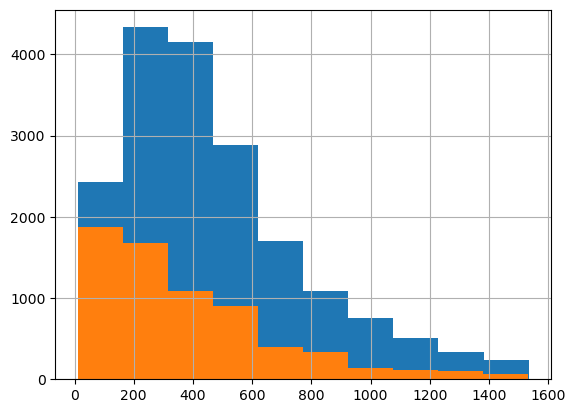

In [15]:
df.groupby("virus")["Length"].hist()

In [16]:
df.groupby("virus")["Length"].describe().round(1).T

virus,0,1
count,18420.0,6699.0
mean,471.7,378.0
std,307.7,297.3
min,11.0,11.0
25%,242.0,150.0
50%,398.0,293.0
75%,621.0,512.0
max,1534.0,1531.0


In [17]:
df.columns

Index(['Entry', 'Entry Name', 'Protein names', 'Organism', 'Sequence',
       'Length', 'Mass', 'Keywords', 'Reviewed', 'Virus hosts',
       'Taxonomic lineage', 'av_mw', 'virus', 'taxon_class', 'Cluster ID',
       'Cluster name', 'UR50_Cluster ID', 'UR50_Cluster members'],
      dtype='object')

In [18]:
df

,Entry,Entry Name,Protein names,Organism,Sequence,Length,Mass,Keywords,Reviewed,Virus hosts,Taxonomic lineage,av_mw,virus,taxon_class,Cluster ID,Cluster name,UR50_Cluster ID,UR50_Cluster members
0,A0A087X1C5,CP2D7_HUMAN,Putative cytochrome P450 2D7 (EC 1.14.14.1),Homo sapiens (Human),MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,515,57489,Cytoplasm;Glycoprotein;Heme;Iron;Membrane;Meta...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",111.63,0,Eukaryota,A0A087X1C5,Cluster: Putative cytochrome P450 2D7,NaN,NaN
1,A0A0B4J2F0,PIOS1_HUMAN,Protein PIGBOS1 (PIGB opposite strand protein 1),Homo sapiens (Human),MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,54,6313,Direct protein sequencing;Membrane;Mitochondri...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",116.91,0,Eukaryota,A0A0B4J2F0,Cluster: Protein PIGBOS1,A0A0B4J2F0,A0A0B4J2F0
2,A0A0C5B5G6,MOTSC_HUMAN,Mitochondrial-derived peptide MOTS-c (Mitochon...,Homo sapiens (Human),MRWQEMGYIFYPRKLR,16,2175,DNA-binding;Mitochondrion;Nucleus;Osteogenesis...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",135.94,0,Eukaryota,A0A0C5B5G6,Cluster: Mitochondrial-derived peptide MOTS-c,A0A0C5B5G6,A0A0C5B5G6
3,A0A0K2S4Q6,CD3CH_HUMAN,Protein CD300H (CD300 antigen-like family memb...,Homo sapiens (Human),MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,201,21806,Alternative splicing;Disulfide bond;Glycoprote...,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",108.49,0,Eukaryota,A0A0K2S4Q6,Cluster: Protein CD300H,A0A0K2S4Q6,A0A0K2S4Q6
4,A0A0U1RRE5,NBDY_HUMAN,Negative regulator of P-body association (P-bo...,Homo sapiens (Human),MGDQPCASGRSTLPPGNAREAKPPKKRCLLAPRWDYPEGTPNGGST...,68,7025,Cytoplasm;mRNA processing;Reference proteome,reviewed,NaN,"cellular organisms (no rank), Eukaryota (super...",103.31,0,Eukaryota,A0A0U1RRE5,Cluster: Negative regulator of P-body association,A0A0U1RRE5,A0A0U1RRE5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25114,Q9YUD1,ORF6_BFDV,Uncharacterized protein ORF6,Beak and feather disease virus (BFDV),MKTSPRLSVIDGVGEEVRPDLFQLVHVVPPNTCEPPEQWLRVTVLL...,88,9846,NaN,reviewed,Gracula [TaxID: 116991]; Psittaciformes [TaxID...,"Viruses (superkingdom), Monodnaviria (no rank)...",111.89,1,Monodnaviria,Q9YUD1,Cluster: Uncharacterized protein ORF6,Q9YUD1,Q9YUD1
25115,Q9YUD2,ORF5_BFDV,Uncharacterized protein ORF5,Beak and feather disease virus (BFDV),MGGAYITSRYWLVPAHVTSRLRLTSFTGHRGVARVDGPMSSLGLNI...,101,10863,NaN,reviewed,Gracula [TaxID: 116991]; Psittaciformes [TaxID...,"Viruses (superkingdom), Monodnaviria (no rank)...",107.55,1,Monodnaviria,Q9YUD2,Cluster: Uncharacterized protein ORF5,Q9YUD2,Q9YUD2
25116,Q9YUD4,ORF3_BFDV,Uncharacterized protein ORF3,Beak and feather disease virus (BFDV),MPYVDFWELSRDFLHFASGHHGSNSSVERAVTVSRHNAQGEYNVPL...,160,17738,NaN,reviewed,Gracula [TaxID: 116991]; Psittaciformes [TaxID...,"Viruses (superkingdom), Monodnaviria (no rank)...",110.86,1,Monodnaviria,Q9YUD4,Cluster: Uncharacterized protein ORF3,Q9YUD4,Q9YUD4
25117,Q9YWQ0,NS3_BAVJK,Non-structural protein 3 (NS3),Banna virus (strain Indonesia/JKT-6423/1980) (...,MNNGQATITRNGGRFEIRCRHLDRDYTMPLPNATSNDNFLDCIKFI...,306,34991,Reference proteome,reviewed,Bos taurus (Bovine) [TaxID: 9913]; Culex annul...,"Viruses (superkingdom), Riboviria (no rank), O...",114.35,1,Riboviria,Q9YWQ0,Cluster: Non-structural protein 3,Q9YWQ0,Q9YWQ0


In [19]:
df_data = df.filter(['Entry', 'Sequence', 'virus', 'Entry Name', 'Protein names', 'Organism',
       'Length', 'Mass', 'Keywords', 'av_mw', 'Virus hosts',
       'Taxonomic lineage',  'Cluster name',
       'UR50_Cluster ID'])

df_data

,Entry,Sequence,virus,Entry Name,Protein names,Organism,Length,Mass,Keywords,av_mw,Virus hosts,Taxonomic lineage,Cluster name,UR50_Cluster ID
0,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,0,CP2D7_HUMAN,Putative cytochrome P450 2D7 (EC 1.14.14.1),Homo sapiens (Human),515,57489,Cytoplasm;Glycoprotein;Heme;Iron;Membrane;Meta...,111.63,NaN,"cellular organisms (no rank), Eukaryota (super...",Cluster: Putative cytochrome P450 2D7,NaN
1,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,0,PIOS1_HUMAN,Protein PIGBOS1 (PIGB opposite strand protein 1),Homo sapiens (Human),54,6313,Direct protein sequencing;Membrane;Mitochondri...,116.91,NaN,"cellular organisms (no rank), Eukaryota (super...",Cluster: Protein PIGBOS1,A0A0B4J2F0
2,A0A0C5B5G6,MRWQEMGYIFYPRKLR,0,MOTSC_HUMAN,Mitochondrial-derived peptide MOTS-c (Mitochon...,Homo sapiens (Human),16,2175,DNA-binding;Mitochondrion;Nucleus;Osteogenesis...,135.94,NaN,"cellular organisms (no rank), Eukaryota (super...",Cluster: Mitochondrial-derived peptide MOTS-c,A0A0C5B5G6
3,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,0,CD3CH_HUMAN,Protein CD300H (CD300 antigen-like family memb...,Homo sapiens (Human),201,21806,Alternative splicing;Disulfide bond;Glycoprote...,108.49,NaN,"cellular organisms (no rank), Eukaryota (super...",Cluster: Protein CD300H,A0A0K2S4Q6
4,A0A0U1RRE5,MGDQPCASGRSTLPPGNAREAKPPKKRCLLAPRWDYPEGTPNGGST...,0,NBDY_HUMAN,Negative regulator of P-body association (P-bo...,Homo sapiens (Human),68,7025,Cytoplasm;mRNA processing;Reference proteome,103.31,NaN,"cellular organisms (no rank), Eukaryota (super...",Cluster: Negative regulator of P-body association,A0A0U1RRE5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25114,Q9YUD1,MKTSPRLSVIDGVGEEVRPDLFQLVHVVPPNTCEPPEQWLRVTVLL...,1,ORF6_BFDV,Uncharacterized protein ORF6,Beak and feather disease virus (BFDV),88,9846,NaN,111.89,Gracula [TaxID: 116991]; Psittaciformes [TaxID...,"Viruses (superkingdom), Monodnaviria (no rank)...",Cluster: Uncharacterized protein ORF6,Q9YUD1
25115,Q9YUD2,MGGAYITSRYWLVPAHVTSRLRLTSFTGHRGVARVDGPMSSLGLNI...,1,ORF5_BFDV,Uncharacterized protein ORF5,Beak and feather disease virus (BFDV),101,10863,NaN,107.55,Gracula [TaxID: 116991]; Psittaciformes [TaxID...,"Viruses (superkingdom), Monodnaviria (no rank)...",Cluster: Uncharacterized protein ORF5,Q9YUD2
25116,Q9YUD4,MPYVDFWELSRDFLHFASGHHGSNSSVERAVTVSRHNAQGEYNVPL...,1,ORF3_BFDV,Uncharacterized protein ORF3,Beak and feather disease virus (BFDV),160,17738,NaN,110.86,Gracula [TaxID: 116991]; Psittaciformes [TaxID...,"Viruses (superkingdom), Monodnaviria (no rank)...",Cluster: Uncharacterized protein ORF3,Q9YUD4
25117,Q9YWQ0,MNNGQATITRNGGRFEIRCRHLDRDYTMPLPNATSNDNFLDCIKFI...,1,NS3_BAVJK,Non-structural protein 3 (NS3),Banna virus (strain Indonesia/JKT-6423/1980) (...,306,34991,Reference proteome,114.35,Bos taurus (Bovine) [TaxID: 9913]; Culex annul...,"Viruses (superkingdom), Riboviria (no rank), O...",Cluster: Non-structural protein 3,Q9YWQ0


In [20]:
df_data.to_csv("SWP_human_or_virus-animal-data.csv.gz",index=False,compression="gzip")

### Load pretrained embeddings

* https://www.uniprot.org/help/embeddings

* can get per protein, per position for swissprot, humans - https://www.uniprot.org/help/downloads#embeddings


In [21]:
import pandas as pd
import h5py
import numpy as np

In [22]:
ALL_IDS = set(list(df_data["Entry"]))
print(len(ALL_IDS)) # 25119 (only UR90 filtered)

25119


In [23]:
# ## ALL Swissprot:
# ####### https://github.com/Rostlab/EAT/blob/main/eat.py#L303
emb_p = '../sprot_t5_embed_eat.h5' ## 4 min to load through. 99% match with data - 25117

# emb_p = "../uniprot_pt_hum_vir_swp_embeddings.h5" ## Only global embeddings. 24230 covered
###########

h5_f = h5py.File(emb_p, 'r')

In [24]:
%%time
## 30 s with uniprot_pt_hum_vir_swp_embeddings
dataset = {pdb_id: np.array(embd) for pdb_id, embd in h5_f.items() if pdb_id in ALL_IDS}

CPU times: user 2min, sys: 15 s, total: 2min 15s
Wall time: 2min 31s


In [25]:
dataset

{'A0A024RBG1': array([ 0.05814 , -0.003479,  0.01237 , ..., -0.0567  ,  0.014175,
        -0.02007 ], dtype=float16),
 'A0A075B6H7': array([-0.0066 ,  0.1047 ,  0.04846, ...,  0.03748,  0.04306,  0.01535],
       dtype=float16),
 'A0A075B6H8': array([ 0.007866,  0.0739  ,  0.06168 , ...,  0.034   ,  0.0601  ,
        -0.002872], dtype=float16),
 'A0A075B6H9': array([-0.004635,  0.0794  ,  0.0446  , ...,  0.04004 ,  0.03632 ,
         0.014496], dtype=float16),
 'A0A075B6I0': array([0.01415, 0.05798, 0.01688, ..., 0.04803, 0.03345, 0.01883],
       dtype=float16),
 'A0A075B6I1': array([-0.0032 ,  0.0639 ,  0.04175, ...,  0.04373,  0.02615,  0.01267],
       dtype=float16),
 'A0A075B6I3': array([0.004955, 0.094   , 0.05362 , ..., 0.02745 , 0.0382  , 0.0199  ],
       dtype=float16),
 'A0A075B6I4': array([0.002739, 0.0647  , 0.0487  , ..., 0.04672 , 0.03644 , 0.01573 ],
       dtype=float16),
 'A0A075B6I6': array([0.01249, 0.0847 , 0.05573, ..., 0.04825, 0.021  , 0.01344],
       dtype=fl

In [26]:
print(len(set(dataset.keys()))," # items with pretrained embedding")

25117  # items with pretrained embedding


In [27]:
dataset["A0A024RBG1"].shape

(1024,)

In [28]:
# with h5py.File(emb_p, "r") as file:
#     print(f"number of entries: {len(file.items())}")
#     for sequence_id, embedding in file.items():
#         print(
#             f"  id: {sequence_id}, "
#             f"  embeddings shape: {embedding.shape}, "
#             f"  embeddings mean: {np.array(embedding).mean()}"
#         )

In [29]:
df_emb = pd.DataFrame(dataset).T#.reset_index().rename(columns={"index":"Entry"})
df_emb = df_emb.add_prefix("global_embed_")
df_emb

,global_embed_0,global_embed_1,global_embed_2,global_embed_3,global_embed_4,global_embed_5,global_embed_6,global_embed_7,global_embed_8,global_embed_9,...,global_embed_1014,global_embed_1015,global_embed_1016,global_embed_1017,global_embed_1018,global_embed_1019,global_embed_1020,global_embed_1021,global_embed_1022,global_embed_1023
A0A024RBG1,0.058136,-0.003479,0.012367,0.005322,-0.004776,0.075256,-0.020065,-0.066528,0.016815,-0.025894,...,-0.071716,0.018265,0.045959,-0.038513,0.017654,0.011627,-0.017166,-0.056702,0.014175,-0.020065
A0A075B6H7,-0.006599,0.104675,0.048462,-0.027679,-0.046692,0.007236,-0.014877,-0.075439,0.011124,0.030609,...,-0.120850,0.056061,-0.097046,-0.049500,-0.033508,-0.025040,0.027435,0.037476,0.043060,0.015350
A0A075B6H8,0.007866,0.073914,0.061676,-0.036102,-0.061646,0.021469,-0.033264,-0.062103,0.033264,0.018646,...,-0.085815,0.064758,-0.108765,-0.042908,-0.037415,0.006985,0.043884,0.033997,0.060089,-0.002872
A0A075B6H9,-0.004635,0.079407,0.044586,-0.020950,-0.050934,0.016891,-0.032776,-0.062042,-0.003380,0.000757,...,-0.108398,0.061951,-0.089844,-0.048737,-0.029388,-0.012711,0.050385,0.040039,0.036316,0.014496
A0A075B6I0,0.014153,0.057983,0.016876,0.007801,-0.047180,0.017578,-0.040924,-0.060822,0.020401,-0.013954,...,-0.089355,0.048981,-0.096802,-0.054840,-0.006927,-0.016968,0.060944,0.048035,0.033447,0.018829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U3KPV4,-0.007858,0.007778,0.063538,0.014320,-0.037811,0.083435,-0.073914,-0.020767,0.031097,0.039093,...,-0.039642,0.016052,0.018173,0.019653,-0.022736,0.019226,0.061584,-0.029266,0.004532,0.027191
V9LLX6,-0.009094,0.051239,0.010605,-0.006607,-0.020966,-0.006283,-0.058228,-0.048828,0.022308,-0.018341,...,-0.065674,-0.027527,-0.029770,-0.048798,-0.002066,0.008278,0.020889,-0.004002,0.044464,-0.038574
W5XKT8,-0.005394,-0.016388,0.024811,0.008492,-0.018326,0.046326,-0.097107,-0.026840,0.071106,0.003702,...,-0.042633,-0.010201,0.014740,-0.003544,-0.025894,0.002317,0.023209,-0.026047,0.038940,0.039948
W6CW81,0.049500,-0.022949,0.097595,0.020721,-0.022400,0.011292,0.015915,-0.145020,-0.044617,-0.047241,...,-0.028198,-0.024551,-0.021088,-0.052551,0.013977,-0.050995,0.081848,0.027420,0.010353,0.009048


In [30]:
s1 = df_emb.shape[0]
df_emb= df_emb.merge(df_data,left_index=True,right_on="Entry",how="inner").drop_duplicates().sample(frac=1)
assert s1 == df_emb.shape[0]

In [31]:
df_emb["UR50_Cluster ID"].astype("category").cat.codes

18191    10620
5179      7866
10960    17368
7849     12575
23449       -1
         ...  
20566     3831
16865       -1
13571    20647
15475    14703
14865    10673
Length: 25117, dtype: int16

In [32]:
X = df_emb.drop(columns=[#Keep the target, since we're saving the output to a file anyway## "virus",
                         'Organism',
                         "Entry Name","Protein names",
                         'Keywords', ## also al eak
                         'Virus hosts', 'Taxonomic lineage',"UR50_Cluster ID"],errors="ignore")
groups = df_emb["UR50_Cluster ID"].astype("category").cat.codes ## make number
y = df_emb["virus"]#.values

print(X.shape)

(25117, 1031)


### make train/test split, split by UR50 group/clusters
* NOTE: taret distribution is different!

In [33]:
sgkf = StratifiedGroupKFold(n_splits=5,shuffle=True, random_state=101)


# train_index, test_index = next(sgkf.split(X, y, groups))
# X_train = X.iloc[train_index].reset_index(drop=True)
# X_test = X.iloc[test_index].reset_index(drop=True)

for i, (train_index, test_index) in enumerate(sgkf.split(X, y, groups)):
    X_train = X.iloc[train_index].reset_index(drop=True)
    X_test = X.iloc[test_index].reset_index(drop=True)

print("Train")
print(X_train.shape[0])
print(X_train[["virus","Length"]].agg(["mean","sum","size"]).round(2))
print(X_train["Cluster name"].nunique())

print("Test:")
print(X_test.shape[0])
print("Test virus mean",X_test["virus"].mean().round(2))
# print(X_test[["virus","Length"]].agg(["mean","sum","size"]).round(2))
print(X_test["Cluster name"].nunique())

Train
20340
         virus      Length
mean      0.28      447.27
sum    5672.00  9097484.00
size  20340.00    20340.00
16810
Test:
4777
Test virus mean 0.21
4488


In [34]:
X_train.drop_duplicates(subset=["Cluster name"]).shape[0] ## Cluster name same as cluster id 

16810

In [35]:
print(X_test[["virus","Length"]].agg(["mean","sum","size"]).round(2))

        virus      Length
mean     0.21      444.29
sum   1027.00  2122393.00
size  4777.00     4777.00


In [36]:
X_train.to_csv("hum_vir_swp-globalEmbed-train.csv.gz",index=False,compression="gzip")
X_test.to_csv("hum_vir_swp-globalEmbed-test.csv.gz",index=False,compression="gzip")